### Part II :  (long version, generating simulated SEDs for all the galaxies)

(1) Read in the master catalog (a SNANA HOSTLIB file) generated in Part I 

(2) For each simulated SN host galaxy, use the EAZY code to make a simulated host galaxy spectrum (from the best-fitting photoz template)

(3) DOABLE, BUT NOT YET DONE: Store each simulated spectrum as an ascii .dat file with wavelength in nm and AB mag (suitable for input to the Subaru ETC).

(4) STILL TBD :  Store the revised master catalog (now updated with SED .dat file names) as a modified SNANA HOSTLIB file (ascii text)

* NOTE: At the moment, I'm working with a shortened library of galaxies, containing just 29 galaxies from the COSMOS field, selected because we think we have decent real-world DEIMOS spectra to compare to. (from the COSMOS DEIMOS paper by Gunther Hasinger, with data available here: 
https://irsa.ipac.caltech.edu/data/COSMOS/spectra/deimos/deimos.html)

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from astropy.io import fits
from glob import glob
from importlib import reload
from matplotlib import pyplot as plt

from astropy import table
from astropy.table import Table, Column
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

import sncosmo
import snhostspec

from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [3]:
reload(snhostspec)

<module 'snhostspec' from '/Users/rodney/Dropbox/src/wfirst/snhostspec.py'>

In [4]:
medsmooth = lambda f,N : np.array( [ np.median( f[max(0,i-N):min(len(f),max(0,i-N)+2*N)]) for i in range(len(f)) ] )

In [5]:
flcdm = FlatLambdaCDM(H0=73, Om0=0.27)

In [6]:
def scale_to_match_imag(wave, flam, imag, medsmooth_window=20, 
                        showplot=False, ax=None):
    """KLUDGE!!  Using sncosmo to make this galaxy SED into a Source so 
    we can integrate into mags using the sncosmo bandmag, and rescale 
    to match a pre-defined mag
    
    wave: wavelength in angstroms
    flam: flambda in erg/s/cm2/A
    imag: sdss i band magnitude to scale to
    """    
    # check that we cover the i band
    if wave[0]>6600:
        wave = np.append([6580], wave)
        flam = np.append([1e-20], flam)
    if wave[-1]<8380:
        wave = np.append(wave, [8400])
        flam = np.append(flam, [1e-20])
    
    # Make a dummy sncosmo Source and scale it to the given sdss i band mag
    phase = np.array([-1, 0, 1, 2]) # need at least 4 phase positions for a source
    flam_med = medsmooth(flam, medsmooth_window)
    flux = np.array([flam_med, flam_med, flam_med, flam_med]) # Use the median-smoothed version
    galsource = sncosmo.TimeSeriesSource(phase, wave, flux)    
    galsource.set_peakmag(imag, 'sdssi', 'ab')

    fout = galsource.flux(0,wave)
    
    if showplot:
        if ax is None:
            ax = plt.gca()

            ax.plot(wave, fout)
            ax.set_xlim(4800,10400)
            #ax.set_ylim(-10,80)
            ax.set_xlabel('wavelength ($\AA$)')
            ax.set_ylabel('f$_\lambda$ (erg/s/cm2/A)')

            # For this galaxy, the scaling factor that makes the spectrum match the i band mag
            scale_factor = np.median(flam_med / galsource.flux(0, wavelength))
            ax.text(0.05,0.9, "scale to match i mag = {:.1f}".format(scale_factor), 
                    ha='left', va='top', transform=ax.transAxes)

    return(wave, fout)


# (1) Read in the master catalog and load the EAZY SED template data

In [7]:
sim1 = snhostspec.SnanaSimData()
sim1.load_hostlib_catalog("DATA/cosmos_example_hostlib.txt")
sim1.load_eazypy_templates("DATA/eazy_13_spectral_templates.dat")

Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat


# (2) Make simulated SEDs from the EAZY coefficients + templates.  Make a summary plot with all 29.

In [45]:
def simulate_eazy_sed_from_coeffs(eazycoeffs, eazytemplatedata, z, 
            returnfluxunit='flambda', returnwaveunit='A',
            limitwaverange=True, savetofile='', **outfile_kwargs):
    """
    Generate a simulated SED from a given set of input eazy-py coefficients
    and eazypy templates.

    NB: Requires the eazy-py package to apply the IGM absorption!
    (https://github.com/gbrammer/eazy-py)

    Optional Args:
    returnfluxunit: ['AB', 'flambda', 'fnu'] TODO: add Jy
        'AB'= return log(flux) as monochromatic AB magnitudes
        'AB25' = return AB mags, rescaled to a zeropoint of 25:  m=-2.5*log10(fnu)+25
        'flambda' = return flux density in erg/s/cm2/A
        'fnu' = return flux density in erg/s/cm2/Hz
    returnwaveunit: ['A' or 'nm'] limitwaverange: limit the output
    wavelengths to the range covered by PFS savetofile: filename for saving
    the output spectrum as a two-column ascii data file (suitable for use
    with the SubaruPFS ETC from C. Hirata.

    Returns
    -------
        wave : observed-frame wavelength, Angstroms or  nm
        flux : flux density of best-fit template, erg/s/cm2/A or AB mag
    """
    # the input data units are Angstroms for wavelength
    # and cgs for flux (flambda): erg s-1 cm-2 Ang-1
    wave_em = eazytemplatedata[0]  # rest-frame (emitted) wavelength
    wave_obs = wave_em * (1 + z)  # observer-frame wavelength
    obsfluxmatrix = eazytemplatedata[1:]
    flam = np.dot(eazycoeffs, obsfluxmatrix) # flux in erg/s/cm2/A
    
    if limitwaverange:
        # to simplify things, we only work with data over the Subaru PFS
        # + WFIRST prism wavelength range, from 200 to 2500 nm
        # (2000 to 25000 Angstroms)
        iuvoir = np.where((wave_obs>2000) & (wave_obs<25000))[0]
        wave_obs = wave_obs[iuvoir]
        wave_em = wave_em[iuvoir]
        flam = flam[iuvoir]
    
    # convert flux units to fnu using :  fnu=(lam^2/c)*flam  ;  c = 3.e18 A/s
    fnu = (wave_em * wave_em / 3.e18) * flam  # flux in erg/s/cm2/Hz
    
    # Confusing previous setup from GB, used to convert to AB mags w/ zpt=25
    #fnu_factor = 10 ** (-0.4 * (25 + 48.6))
    # flam_spec = 1. / (1 + z) ** 2
    # obsflux = sedsimflux * fnu_factor * flam_spec   
    
    try:
        import eazy.igm
        igmz = eazy.igm.Inoue14().full_IGM(z, wave_obs)
        obsflux *= igmz
    except:
        pass
    
    if returnfluxunit=='AB':
        # convert from flux density fnu into monochromatic AB mag:
        returnflux = -2.5 * np.log10(fnu) - 48.6
    elif returnfluxunit=='AB25':
        # convert from flux density fnu into AB mags for zpt=25:
        returnflux = -2.5 * np.log10(fnu) + 25
    elif returnfluxunit=='fnu':
        returnflux = fnu
    elif returnfluxunit.startswith('flam'):
        returnflux = flam
    else:
        print("I don't recognize flux unit {}".format(returnfluxunit))
        return None,None
        
    if returnwaveunit=='nm':
        returnwave = wave_obs / 10.
    elif returnwaveunit.startswith('A'):
        returnwave = wave_obs
    else:
        print("I don't recognize wave unit {}".format(returnwaveunit))
        return None,None

    if savetofile:
        out_table = Table()
        outcol1 = Column(data=wave_obs, name='Angstroms')
        outcol2 = Column(data=flam, name='flambda')
        out_table.add_columns([outcol1, outcol2])
        out_table.write(savetofile, **outfile_kwargs)

    return returnwave, returnflux


In [46]:
def mAB_from_flambda(flambda, wave):
    """ Convert from flux density f_lambda in erg/s/cm2/A 
    into AB mag
    
    flambda: flux density f_lambda (erg/s/cm2/A)
    wave : wavelength in angstroms
    
    (see https://en.wikipedia.org/wiki/AB_magnitude)
    """
    return(-2.5 * np.log10(3.34e4 * wave * wave * (flambda / 3631)))


def getdeimosdat(galid, medsmoothpix=20, returnfluxunit='AB', returnwaveunit='A', extension='fits',
                 imag=None):
    deimosfilename = "DATA/cosmos_example_spectra/cosmos_example_spec1d_{0}.{1}".format(galid, extension)
   
    if extension=='fits':
        deimosdat = Table.read(deimosfilename, format='fits')
        f = np.array(deimosdat['FLUX'][0])
        w = np.array(deimosdat['LAMBDA'][0])
        ivalid = np.where((-1000<f) & (f<100))[0]
    elif extension=='txt':
        deimosdat = Table.read(deimosfilename, format='ascii.commented_header', header_start=-1, data_start=0)
        f = np.array(deimosdat['flux'])
        w = np.array(deimosdat['wavelength'])
        ivalid = np.where((-100<f) & (f<100))[0]

    f = f[ivalid] * 1e-17 # erg/s/cm2/A
    w = w[ivalid] 

    if imag is not None:
        wsmooth, fsmooth = scale_to_match_imag(w, f, imag, medsmooth_window=medsmoothpix, showplot=False, ax=None)
        
    if returnfluxunit=='AB':
        f = mAB_from_flambda(f, w)
        fsmooth = mAB_from_flambda(fsmooth, wsmooth)
    if returnwaveunit=='nm':
        w = w / 10
        wsmooth = wsmooth/10
        
    inotnan = np.isfinite(f)
    fnotnan = f[inotnan]
    wnotnan = w[inotnan]  
    
    if imag is None:
        wsmooth = wnotnan
        fsmooth = medsmooth(fnotnan,medsmoothpix)

    return(wnotnan, fnotnan, wsmooth, fsmooth)


In [47]:
# Make a composite catalog with all the info from the CANDELS hostlib 
def join_candels_to_deimos(deimoscatfile="DATA/cosmos_example_spectra/cosmos_example_spectra.txt",
                        candelscatfile='candels_hostlib.txt'):
    cat1 = ascii.read(deimoscatfile, format='fixed_width')
    cat2 = ascii.read(candelscatfile)
    catjoin = table.join(cat1, cat2, keys=['GALID'])
    return(catjoin)

In [48]:
# read in the filter data, downloaded from http://svo2.cab.inta-csic.es/svo/theory//fps3/
# also available at: https:// wfirst.gsfc.nasa.gov/science/sdt_public/wps/references/ instrument/WFIRST-WFI-Transmission_160720.xlsm
J_hst = ascii.read("DATA/HST_WFC3_IR.F125W.dat")
H_hst = ascii.read("DATA/HST_WFC3_IR.F160W.dat")
J_wfirst = ascii.read("DATA/WFIRST_WFI.J129.dat")
H_wfirst = ascii.read("DATA/WFIRST_WFI.H158.dat")

def getJHmags(wave, flambda):
    """integrate over the J and H bandpasses and return an AB mag"""

In [49]:
galid = 205925
deimoscat = join_candels_to_deimos()
ideimoscat = np.where(deimoscat['GALID']==galid)[0][0]
eazycoeffs = np.array([deimoscat[col][ideimoscat] for col in sim1.simdata.colnames if col.startswith('eazy_coeff')])

In [50]:
def plot_spec_comparison(galid, medsmooth_window=20, rescaledeimos=True, ax=None):
    """Plot flux vs wavelength for the given galaxy ID, showing both the observed 
    DEIMOS spectrum and the Eazy-simulated spectrum. """
    if ax is None:
        fig = plt.figure(figsize=[8,6])
        ax = fig.add_subplot(1,1,1)

    # row index for this galaxy in the simdata table
    # igal = np.where(sim1.simdata['GALID'] == galid)[0][0]

    # read in the eazy spectral templates data 
    # NOTE: could do this without loading the whole hostlib as a SnanaSimData object, would just need to grab
    # the code from snhostspec 
    sim1 = snhostspec.SnanaSimData()
    sim1.load_hostlib_catalog("DATA/cosmos_example_hostlib.txt")
    sim1.load_eazypy_templates("DATA/eazy_13_spectral_templates.dat")
    
    # read in the mag data for the DEIMOS spectra
    deimoscat = join_candels_to_deimos()
    #deimoscat = ascii.read("DATA/cosmos_example_spectra/cosmos_example_spectra.txt", format='fixed_width')
    ideimoscat = np.where(deimoscat['GALID']==galid)[0][0]
    imag = deimoscat['imag'][ideimoscat]
    kmag = deimoscat['kmag'][ideimoscat]   

    sdssu = deimoscat['sdssu_fit'][ideimoscat]
    sdssg = deimoscat['sdssg_fit'][ideimoscat]   
    sdssr = deimoscat['sdssr_fit'][ideimoscat]
    sdssi = deimoscat['sdssi_fit'][ideimoscat]   
    sdssz = deimoscat['sdssz_fit'][ideimoscat]

    twomassj = deimoscat['2massj_fit'][ideimoscat]
    twomassh = deimoscat['2massh_fit'][ideimoscat]

    z = deimoscat['ZTRUE'][ideimoscat]   
    Jmag = deimoscat['hst_f125w_obs'][ideimoscat]
    Hmag = deimoscat['hst_f160w_obs'][ideimoscat]    

    
    # read in the actual observed DEIMOS spectrum 
    if rescaledeimos:
        # rescale to match the observed SDSS i band mag
        wdeimos, mdeimos, wsmooth, mdeimos_smooth = getdeimosdat(
            galid, medsmooth_window, returnwaveunit='A', returnfluxunit='AB', 
            extension='fits', imag=imag)        
    else:
        # Use the observed DEIMOS spectrum without rescaling
        wdeimos, mdeimos, wsmooth, mdeimos_smooth = getdeimosdat(
            galid, medsmooth_window, returnwaveunit='A', returnfluxunit='AB', 
            extension='fits', imag=None)

    #import pdb; pdb.set_trace()
    #ax.plot(wdeimos, mdeimos, label='deimos', color='0.5', alpha=0.2)   
    ax.plot(wsmooth, mdeimos_smooth, label='Observed (DEIMOS) rescaled to match observed i mag', color='b')


    # plot the SDSS, 2mass and HST mags
    ax.errorbar(7500, imag, xerr=500, marker='s', color='k', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(12500, Jmag, xerr=12500-11000,  marker='s', color='k', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(16000, Hmag, xerr=16000-13900,  marker='s', color='k', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(21590, kmag, xerr=2620,  marker='s', color='k', ms=8, zorder=1000, label='observed i, HST-J, HST-H, Ks')

    ax.errorbar(3543*(1+z), sdssu, xerr=500*(1+z), marker='d', color='m', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(4770*(1+z), sdssg, xerr=500*(1+z), marker='d', color='m', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(6231*(1+z), sdssr, xerr=500*(1+z), marker='d', color='m', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(7625*(1+z), sdssi, xerr=600*(1+z), marker='d', color='m', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(9134*(1+z), sdssz, xerr=800*(1+z), marker='d', color='m', ms=8, zorder=1000, label='rest-frame SDSS/2MASS')
    ax.errorbar(12350*(1+z), twomassj, xerr=1620*(1+z), marker='d', color='m', ms=8, zorder=1000, label='_nolabel')
    ax.errorbar(16620*(1+z), twomassh, xerr=2510*(1+z), marker='d', color='m', ms=8, zorder=1000, label='_nolabel')

    
    # plot the EAZY simulated spectrum
    eazycoeffs = np.array([deimoscat[col][ideimoscat] for col in sim1.simdata.colnames if col.startswith('eazy_coeff')])
    outfilename = "DATA/cosmos_example_spectra/cosmos_example_host_simspec_{:6d}.fits".format(galid)
    wobs, mobs = simulate_eazy_sed_from_coeffs(
        eazycoeffs, sim1.eazytemplatedata, z, returnwaveunit='A', returnfluxunit='AB25',
        savetofile=outfilename, overwrite=True)
    ax.plot(wobs, mobs, label='EAZY SED fit', color='g', zorder=100)
    
    ax.set_xlim(3000,25000)
    #ax.set_ylim(-0.25*1e-16,0.3*1e-16)
    #ax.set_ylim(27, 20)
    ax.text(0.95,0.95, galid, ha='right', va='top', transform=ax.transAxes)
    ax.text(0.95,0.88, "z={0}".format(z), ha='right', va='top', transform=ax.transAxes)

    ax.legend(loc='upper left')
    ax.invert_yaxis()
    ax.grid()
    ax.set_xlabel('Observed Wavelength (Angstroms)')
    ax.set_ylabel("AB mag")
    plt.tight_layout()
    #plt.savefig("cosmos_example_spec_eazysims.pdf")

    return(mdeimos_smooth)

Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat


/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


(3000, 28000)

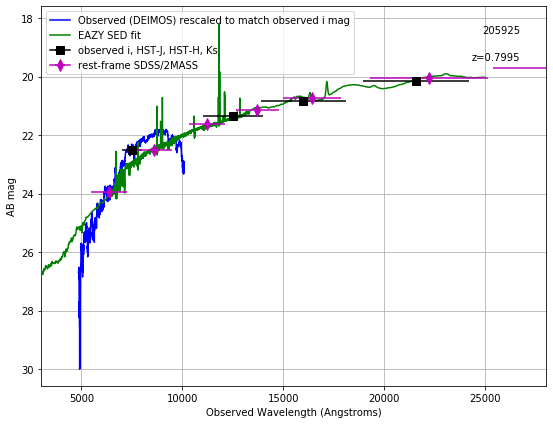

In [51]:
fds = plot_spec_comparison(205925, rescaledeimos=True, medsmooth_window=50)
ax = plt.gca()
ax.set_xlim(3000, 28000)
#ax.set_ylim(26,18)

Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat


/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNAN

Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNAN

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  app.launch_new_instance()


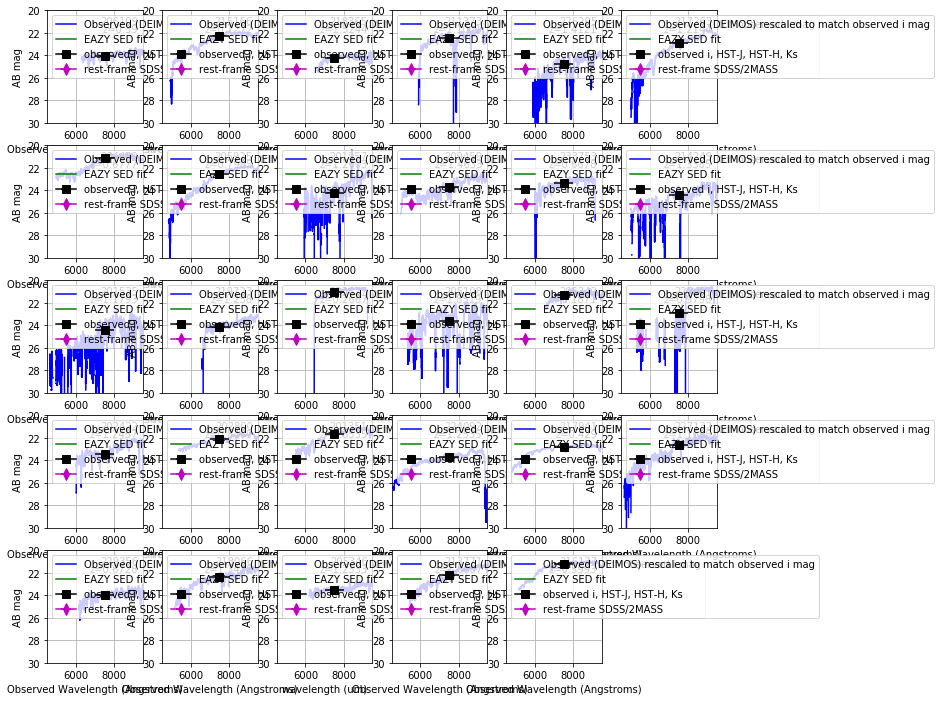

In [29]:
fig = plt.figure(figsize=[12,12])
#fig = plt.figure(figsize=[12,4])
for igal in range(len(sim1.simdata)):
    galid = sim1.simdata['GALID'][igal]
    ax = fig.add_subplot(5,6,igal+1)
    #ax = fig.add_subplot(1,4,igal+1)
    plot_spec_comparison(galid, ax=ax, rescaledeimos=True, medsmooth_window=50)
    
    ax.set_xlim(4500, 9500)
    ax.set_ylim(30,20)
    
    if igal ==12:
        ax.set_ylabel("AB mag")
    if igal == 26:
        ax.set_xlabel("wavelength (um)")
plt.tight_layout()
plt.savefig("cosmos_example_spec_eazysims.pdf")

Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat


/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNAN

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNAN

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNANA HOSTLIB file DATA/cosmos_example_hostlib.txt
Loaded Eazypy template SEDs from DATA/eazy_13_spectral_templates.dat
Initiliazed an empty WfirstSimData object
Loaded galaxy data from SNAN

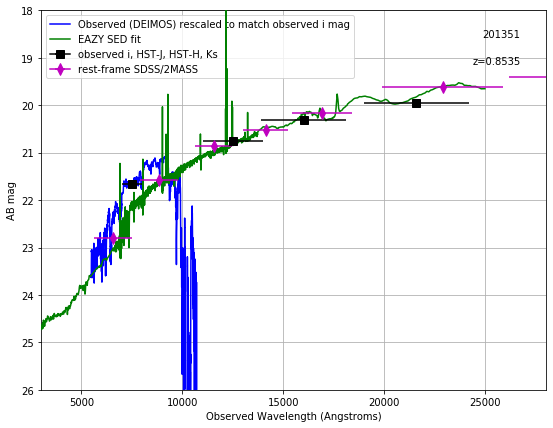

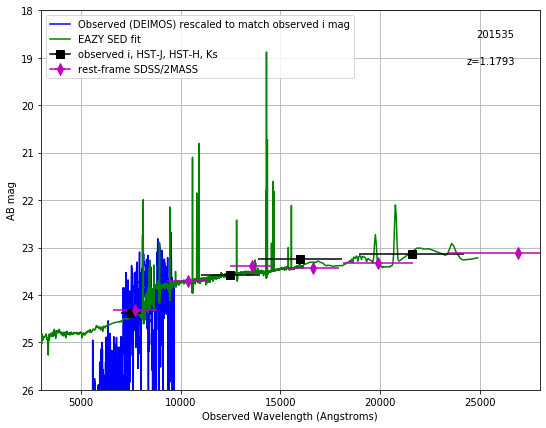

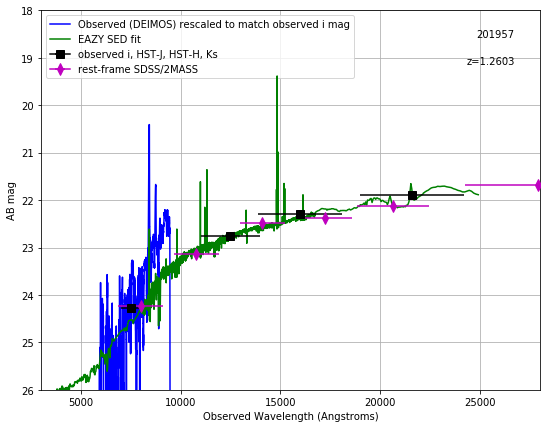

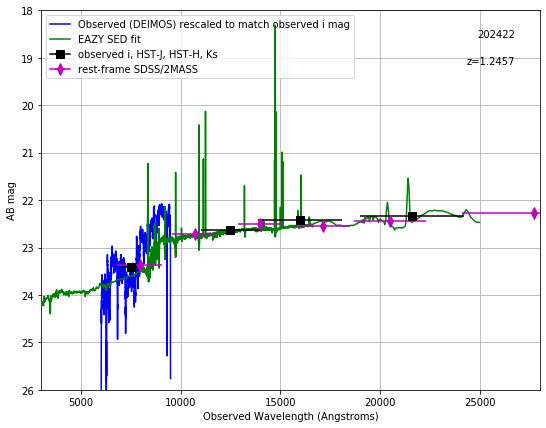

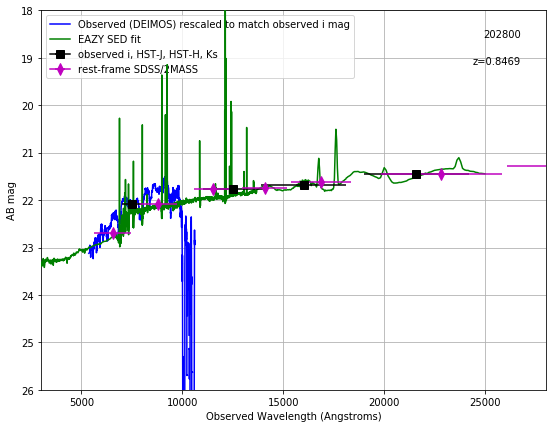

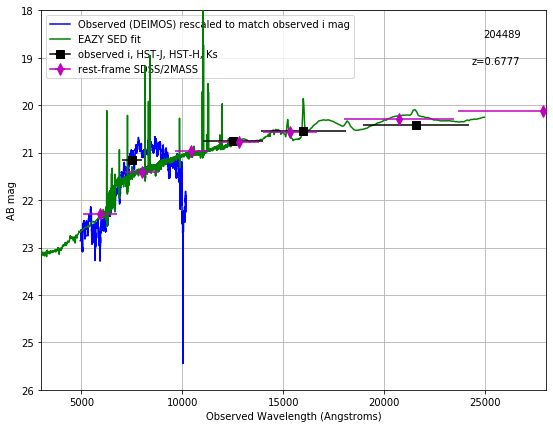

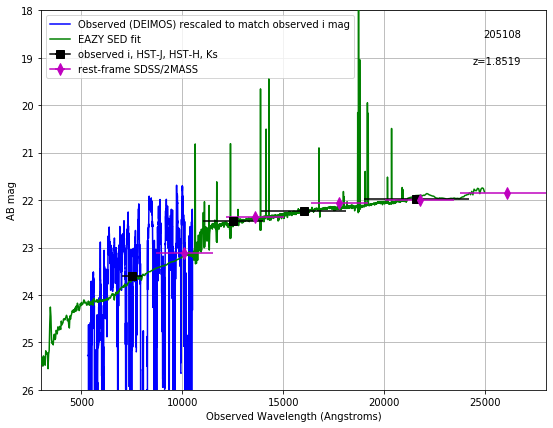

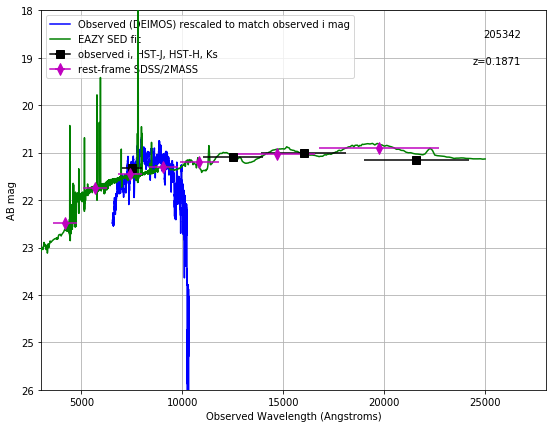

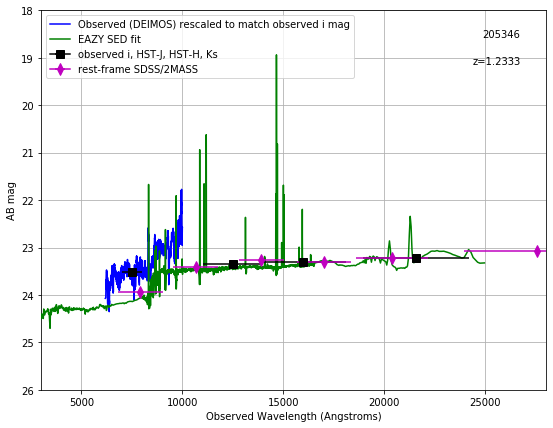

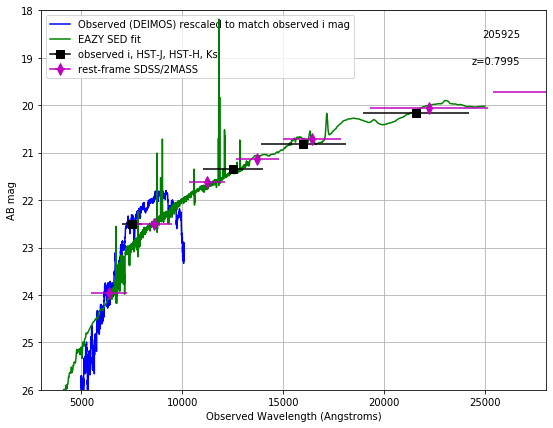

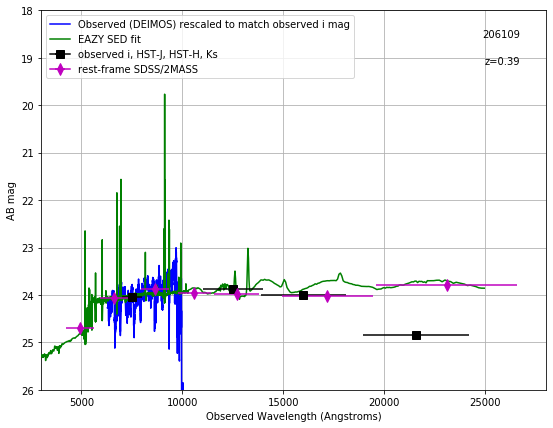

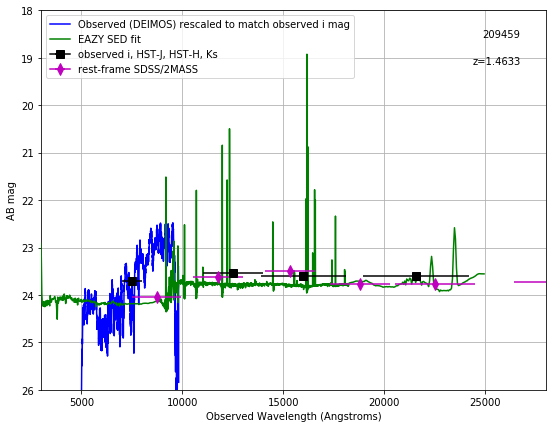

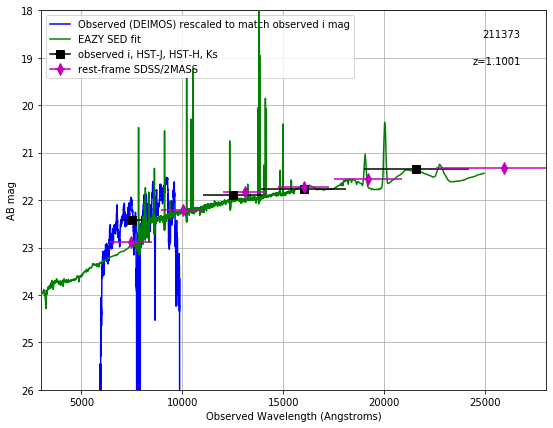

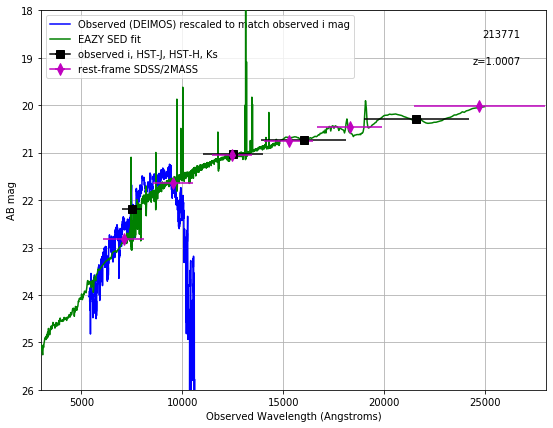

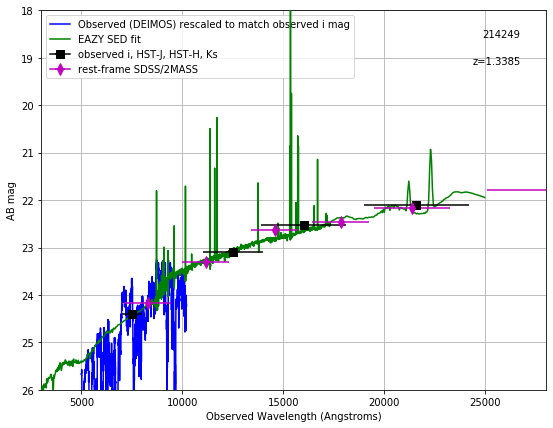

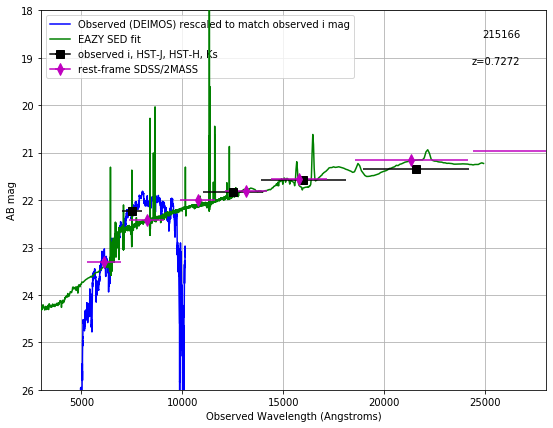

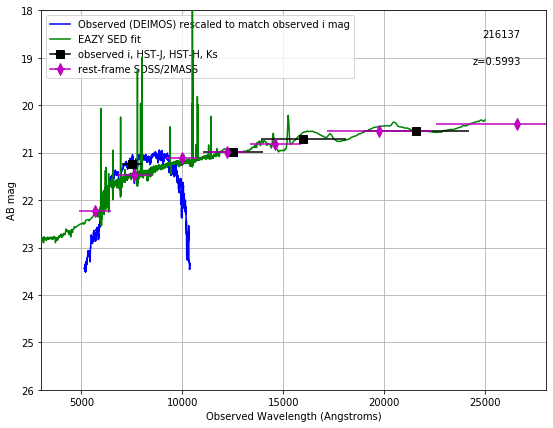

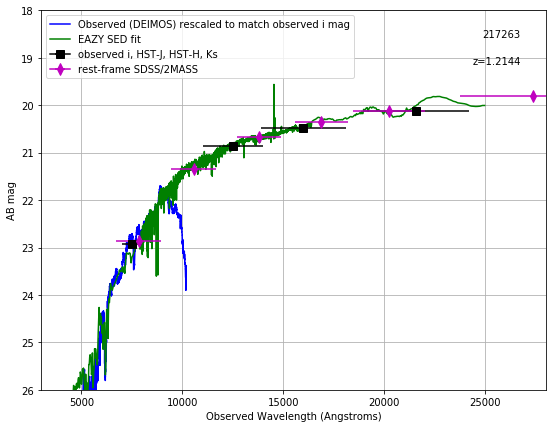

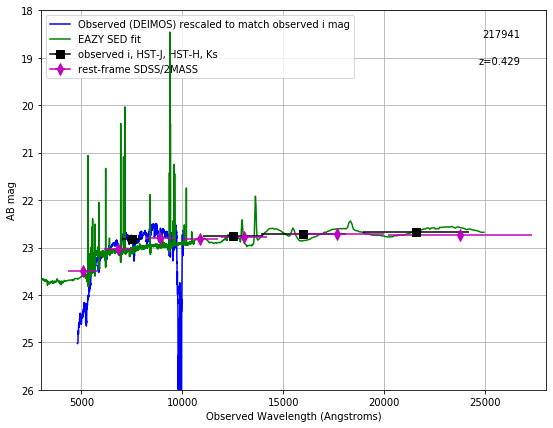

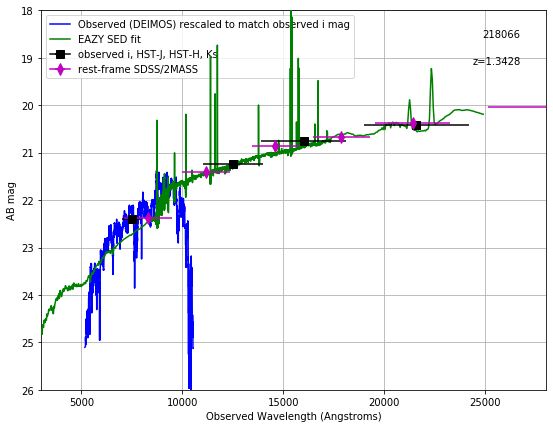

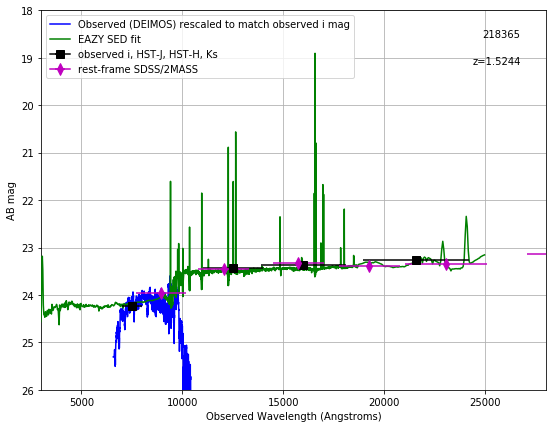

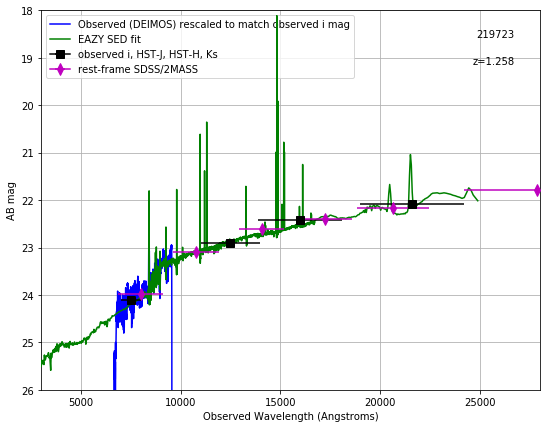

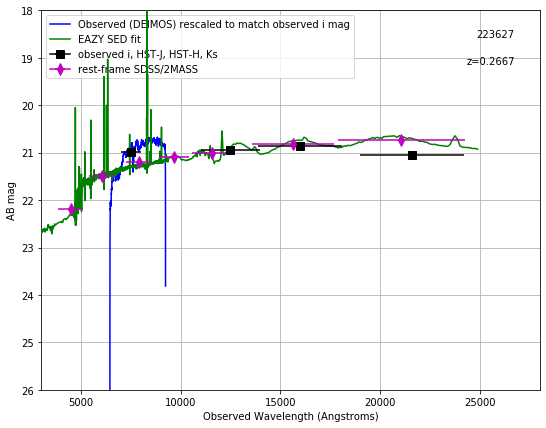

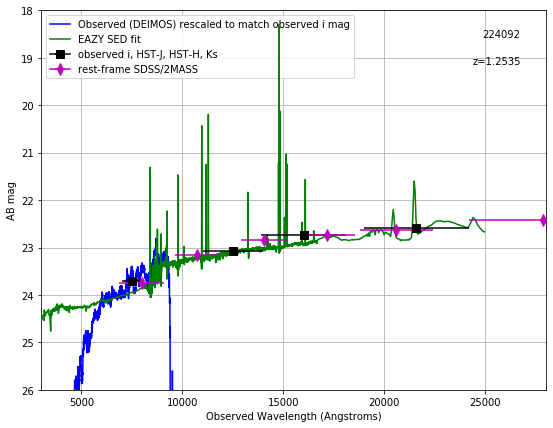

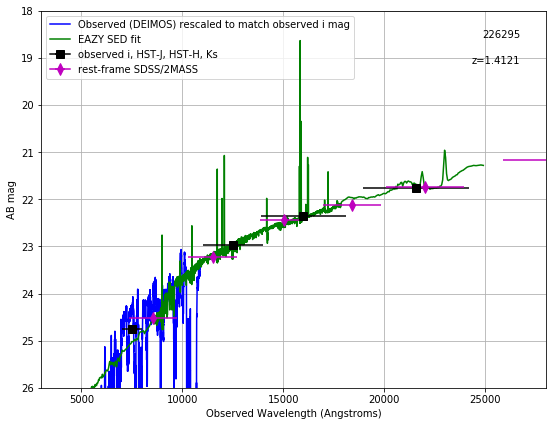

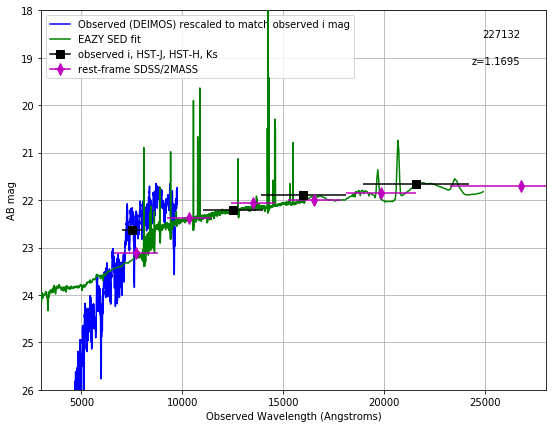

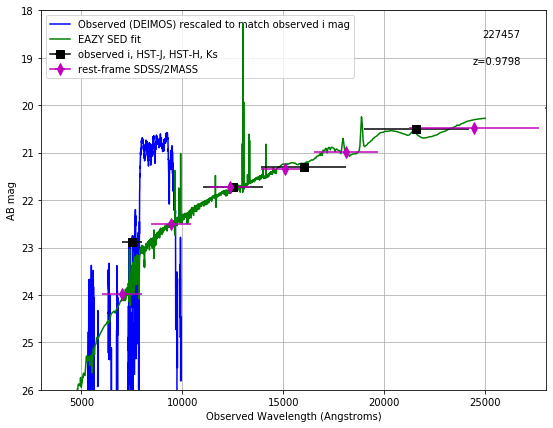

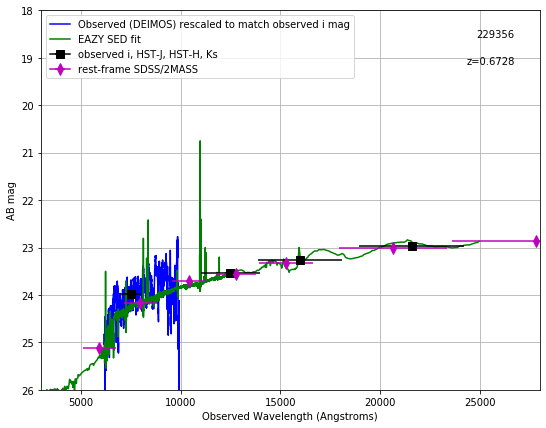

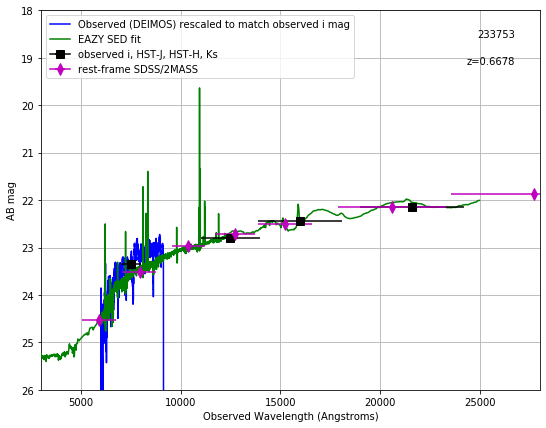

In [52]:
for galid in deimoscat['GALID']:
    fds = plot_spec_comparison(galid, rescaledeimos=True, medsmooth_window=50)
    ax = plt.gca()
    ax.set_xlim(3000, 28000)
    ax.set_ylim(26,18)
    plt.savefig("DATA/cosmos_example_spectra/cosmos_example_specphot_comparison_{}.png".format(galid))

In [37]:
# Write out a new cosmos_example_hostlib.txt file, extracting just the 29 cosmos example galaxies from the 100k in the candels_hostlib.txt
candelscat = ascii.read("candels_hostlib_v4.txt")
cosmoscat = ascii.read("DATA/cosmos_example_hostlib.txt")
matching_galids, imatch1, imatch2 = np.intersect1d(candelscat['GALID'],cosmoscat['GALID'], return_indices=True )
cosmoscatnew = candelscat[imatch1]

In [38]:
cosmoscatnew.write("cosmos_example_hostlib_v4.txt", format='ascii.fixed_width', delimiter='')